In [1]:
import matplotlib.pyplot as plt
import qtensor
import xarray as xar
import sys
import pickle
import scipy as sc
sys.path.append('../data/generators/') # required to import miplog helper
import miplog_helper
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

In [2]:
def to_mh(item) -> miplog_helper.MiplogData:
    starts, *diffs = item
    return miplog_helper.MiplogData.from_start_and_diffs(starts, diffs)
def get_colors(n, cm=plt.cm.plasma, offset=0.2):
    return [cm(x) for x in np.linspace(offset, 1-offset, n)]

In [3]:
qvar_data = xar.open_dataarray('../data/qaoa_variance_nsamples1000.nc')
gurobi_single_run = pickle.load(open('../data/gurobi_single_N256_seeds100.pkl', 'rb'))
gurobi = pickle.load(open('../data/gurobi_match_d3_gpsymLin2.pkl', 'rb'))
mqlib = pickle.load(open('../data/mqlib_data.pkl', 'rb'))
flip_repetetive = np.load('../data/FLIP_repetetive.npy')

In [5]:
gurobi.coords

Coordinates:
  * N        (N) int64 30 64 100 150 320 490 ... 35000 40000 50000 75000 100000
  * seed     (seed) int64 10 11 12 13 14 15 16 ... 203 204 205 206 207 208 209

In [6]:
def approx_ratio(p):
    ps = [qtensor.tools.BETHE_QAOA_VALUES[str(p)]['val'] for p in range(1, 12)]
    AR = ps[p-1]
    if AR>0:
        return AR
    
def nan50mean(x):
    if sum(np.isnan(x))>len(x)/2:
        return np.nan
    return np.nanmean(x)
        
def plot_with_statband_50_mean(x, y, perc=.8, *args, **kwargs):
    mn = np.apply_along_axis(nan50mean, -1, y)
    thresh = 100*(1-perc)/2
    up = np.nanpercentile(y, 100-thresh, -1)
    dn = np.nanpercentile(y, thresh, -1)
    plt.plot(x, mn, *args, **kwargs)
    color = kwargs.get('color')
    plt.fill_between(x, up, dn, alpha=.1, color=color)

In [7]:
def get_cut_frac(mh, ts, N):
    no_edges = 1.5*N
    up, low = mh.get_bounds_at(ts)
    if (low is None):
        return None
    return  low/no_edges

def get_cut_frac_ub(mh, ts, N):
    no_edges = 1.5*N
    up, low = mh.get_bounds_at(ts)
    if (low is None):
        return None
    return  up/no_edges

In [8]:
def get_label(x):
    if x>=60*60:
        return f'{round(x/60/60)} h'
    if x>=60:
        return f'{round(x/60)} min'
    elif x>=1:
        return f'{round(x)} s'
    elif x>=0.001:
        return f'{round(x*1000)} ms'
    elif x>0.000001:
        return f'{round(x*1000000)} us'
    else:
        return '0'

## Determine variance coefficient

Text(0, 0.5, 'Stddev of cut fraction')

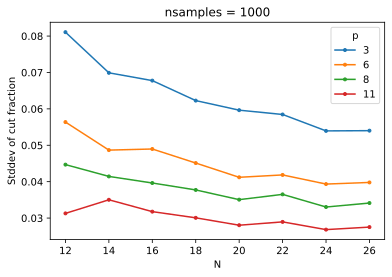

In [9]:
smp = qvar_data.std('sample').mean('graph_seed') # scales as 1/sqrt(N)
smp.plot(x='N', hue='p', marker='.')
plt.ylabel('Stddev of cut fraction')

<xarray.DataArray (p: 4, nsamples: 1)>
array([[0.26981028],
       [0.19263068],
       [0.16156896],
       [0.12839445]])
Coordinates:
  * p         (p) int32 3 6 8 11
  * nsamples  (nsamples) int32 1000

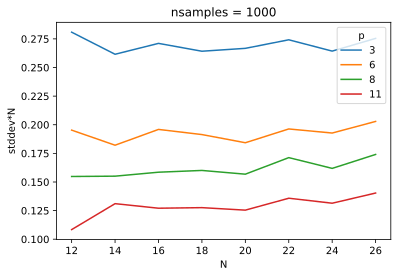

In [10]:
smp = qvar_data.std('sample').mean('graph_seed') # scales as 1/sqrt(N)
smp_norm = smp*np.sqrt(smp.N)
smp_norm.plot(x='N', hue='p') # should be close to linear
plt.ylabel('stddev*N')
smp_norm.mean('N')

In [11]:
qvar_coef = 0.194
qvar_256 = qvar_coef/np.sqrt(256)
print("Variance for 256-Node graph", qvar_256)

Variance for 256-Node graph 0.012125


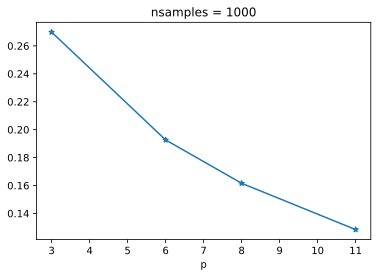

In [12]:
smp_norm.mean('N').plot(x='p', marker='*')

In [13]:
def get_E_N(N, sigma=1, truncate_up=6):
    x = np.linspace(-6, truncate_up, 200)
    errf = sc.special.erf(x/sigma/np.sqrt(2))/2+1/2
    gaus = sc.stats.norm.pdf(x, scale=sigma)
    pdf = N*errf**(N-1)*gaus
    mean = np.sum(pdf*x)/np.sum(pdf)
    return mean

## Plot

In [14]:
gurobi_single_mh = [to_mh(x) for x in gurobi_single_run]
#gurobi_single_mh = [to_mh(x) for x in gurobi.sel(N=5000).data]

In [15]:
select_N = [256]

In [16]:
def get_mqlib_at_time(history, ts):
    times = np.array(history['times'])
    costs = np.array(history['costs'])
    indices = np.arange(len(times))
    if ts>times[-1]:
        return costs[-1]
    ix = min(indices[times>ts])
    return costs[ix]

In [17]:
mqlib_times = 2**(np.linspace(-14, 0, 30))
#mqlib_times = np.concatenate((mqlib_times, [10*60]))
mqlib_costs = []
for seed in mqlib:
    mc = [get_mqlib_at_time(seed['history'], ts) for ts in mqlib_times]
    mqlib_costs.append(mc)
mqlib_costs = np.array(mqlib_costs).T/select_N/3*2

/home/plate/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


maxqaoa 0.9173611111111112
maxqaoa 0.9173611111111112


<ipython-input-13-bbe45f1d7236>:6: RuntimeWarning: invalid value encountered in double_scalars
  mean = np.sum(pdf*x)/np.sum(pdf)


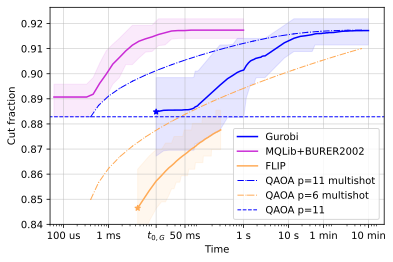

In [28]:
N_samples = 20    
select_p = [20, 14, 12]
nfigs = len(select_N)

times = np.concatenate([
    np.linspace(0.001, 0.1, 20),
    np.linspace(0.3, 3, 20),
    np.linspace(3, 100, 20)
    , np.linspace(100, 600, 20)
])
colors = get_colors(3, offset=0.25, cm=plt.cm.gnuplot2)


fig, axs = plt.subplots(1, 1, figsize=(6*nfigs, 4), sharey='row')
i=0
# -- Handle axes: case where 1 axis and many
N = select_N[i]
try: 
    ax = axs[i] # only for single row layout
except:
    ax = axs
plt.sca(ax)
# --


# -- Quantum samples
time_q = 0.1

# -- Handle gurobi match
# ---- Calculate lower bound for various times
# ------ Upper bound
gaps = []
for ts in times:
    at_time = [get_cut_frac_ub(mh, ts, N) for mh in gurobi_single_mh]
    gaps.append(at_time)
gaps = np.array(gaps).astype(np.float)
#plot_with_statband_50_mean(times, gaps, label='Gurobi upper bound', color=colors[1])
# ------ Lower bound
gaps = []
for ts in times:
    at_time = [get_cut_frac(mh, ts, N) for mh in gurobi_single_mh]
    gaps.append(at_time)
gaps = np.array(gaps).astype(np.float)
plot_with_statband_50_mean(times, gaps, label='Gurobi', color=colors[0])

# ---- Add a start for t0
t0_index = min(
    np.arange(len(times))[
        ~np.isnan(np.apply_along_axis(nan50mean, -1, gaps))
    ] )
t0 = times[t0_index]
cf0 = np.nanmean(gaps[t0_index])
plt.plot([t0], [cf0], marker='*', color=colors[0])
# ---- 

# -- MQLib data
plot_with_statband_50_mean(mqlib_times, mqlib_costs, label='MQLib+BURER2002', color=colors[1])

# -- FLIP data
times_s, cuts_s = flip_repetetive
times_flip = np.average(times_s, 0)
plot_with_statband_50_mean(times_flip, cuts_s.T, label='FLIP', color=colors[2])
##plt.semilogx(np.average(times_flip[:,1::],0), th50, label='FLIP', color=colors[2])
##plt.fill_between(np.average(times_flip[:,1::],0),th10,th90,alpha=0.1, color=colors[2])
# ---- Add a start for t0
flip_t0_index = 0
flip_t0 = times_flip[flip_t0_index]
flip_cf0 = np.mean(cuts_s.T[flip_t0_index])
plt.plot([flip_t0], [flip_cf0], marker='*', color=colors[2])
# ---- 
# --



# -- QAOA multishot lines
p = 11
def plot_qaoa(p, color, qaoa_t0=1/5000):
    Ns = 2**np.arange(0, 29)
    #qaoa_sr_perLayer = 25000
    sampling_freq = 5000
    times_q = Ns/sampling_freq + qaoa_t0
    filt = times_q<60*10
    sigma = smp_norm.mean('N').sel(p=p).data[0]/np.sqrt(N)
    
    max_qaoa = np.max(mqlib_costs.mean(axis=-1))
    print('maxqaoa', max_qaoa)
    truncate = (max_qaoa - approx_ratio(p))/sigma
    en = np.array([get_E_N(n, truncate_up=truncate) for n in Ns])*sigma+approx_ratio(p)
    plt.plot(times_q[filt], en[filt], linestyle='-.', marker=',', color=color, linewidth=1, 
               label=f'QAOA p={p} multishot'
              )
plot_qaoa(11, colors[0])
plot_qaoa(6, colors[2])

# --

plt.xscale('log')
ylim = plt.gca().get_ylim()
xlim = plt.gca().get_xlim()
# -- QAOA lines
plt.hlines(approx_ratio(11), xlim[0], xlim[1], linestyle='--', color=colors[0], linewidth=1, 
           label=f'QAOA p={11}'
          )
#plt.hlines(approx_ratio(6), xlim[0], xlim[1], linestyle='--', color=colors[3], linewidth=1, 
#           label=f'QAOA p={6}'
#          )
# --



plt.xlim(0.00005, max(*xlim))
plt.ylim(0.84, ylim[1]*1.0)
# --
plt.grid(alpha=0.5)


# -- Ticks prettify
ticks = list(plt.gca().get_xticks())[1:-1]
#ticks = [0, 0.05, 1, 10, 60, 300, 30*60 , t0, 0]
ticks = [0, 0.0001, 0.001, 0.05, 1, t0, 10, 60, 10*60 , 0]

labels = [get_label(x) if x!=t0 else '$t_{0,G}$' for x in ticks]
plt.xticks(ticks=ticks[1:-1], labels=labels[1:-1])
# --
plt.legend()
plt.ylabel('Cut fraction')
plt.xlabel('Time')

plt.savefig('./pdf/gurobi_timebounds.pdf')

In [19]:
smp_norm.mean('N').sel(p=p)

<xarray.DataArray (nsamples: 1)>
array([0.12839445])
Coordinates:
    p         int32 11
  * nsamples  (nsamples) int32 1000

In [20]:
get_E_N(2)

0.5641895743846366

(array([  1.,   0.,   0.,   0.,   0.,   3.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          4.,   0.,   0.,   0.,   0.,  13.,   0.,   0.,   0.,   0.,   0.,
         23.,   0.,   0.,   0.,   0., 107.,   0.,   0.,   0.,   0.,   0.,
        150.,   0.,   0.,   0.,   0., 698.]),
 array([0.66666667, 0.67128205, 0.67589744, 0.68051282, 0.68512821,
        0.68974359, 0.69435897, 0.69897436, 0.70358974, 0.70820513,
        0.71282051, 0.7174359 , 0.72205128, 0.72666667, 0.73128205,
        0.73589744, 0.74051282, 0.74512821, 0.74974359, 0.75435897,
        0.75897436, 0.76358974, 0.76820513, 0.77282051, 0.7774359 ,
        0.78205128, 0.78666667, 0.79128205, 0.79589744, 0.80051282,
        0.80512821, 0.80974359, 0.81435897, 0.81897436, 0.82358974,
        0.82820513, 0.83282051, 0.8374359 , 0.84205128, 0.84666667,
        0.85128205, 0.85589744, 0.86051282, 0.86512821, 0.86974359,
        0.87435897, 0.87897436, 0.88358974, 0.

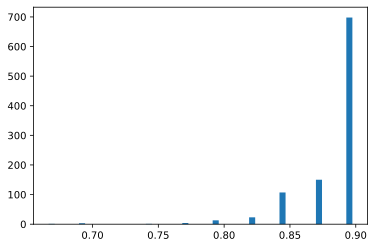

In [20]:
samples = qvar_data.sel(N=26, p=11, graph_seed=0)
plt.hist(samples.data[0], bins=50)

---